In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Concatenate,UpSampling2D,Dropout,Input,GlobalAveragePooling2D,AveragePooling2D,Conv2DTranspose
from tensorflow.keras.metrics import Precision,Recall
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Accuracy,Precision , Recall
from sklearn.model_selection import train_test_split

import numpy as np 
import matplotlib.pyplot as plt


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def segnet(input_size):
    """encoder"""
    input_scan = Input(input_size)
    conv1 = Conv2D(32,(3,3),padding="same",activation="relu")(input_scan)
    conv1 = Conv2D(32,(3,3),padding="same",activation="relu")(conv1)
    pool1 = MaxPooling2D((2,2),strides=2)(conv1)
    conv2 = Conv2D(64,(3,3),padding="same",activation="relu")(pool1)
    conv2 = Conv2D(64,(3,3),padding="same",activation="relu")(conv2)
    pool2 = MaxPooling2D((2,2),strides=2)(conv2)
    conv3 = Conv2D(128,(3,3),padding="same",activation="relu")(pool2)
    conv3 = Conv2D(128,(3,3),padding="same",activation="relu")(conv3)
    pool3 = MaxPooling2D((2,2),strides=2)(conv3)
    conv4 = Conv2D(256,(3,3),padding="same",activation="relu")(pool3)
    conv4 = Conv2D(256,(3,3),padding="same",activation="relu")(conv4)
    pool4 = MaxPooling2D((2,2),strides=2)(conv4)
    conv5 = Conv2D(512,(3,3),padding="same",activation="relu")(pool4)
    
    p1 = GlobalAveragePooling2D()(conv5)
    p1 = tf.keras.layers.Reshape((1,1,512))(p1)
    p1 = Conv2D(64,(1,1))(p1)
    p1 = UpSampling2D((256,256))(p1)
    p2 = AveragePooling2D((2,2))(conv5)
    p2 = Conv2D(64,(1,1))(p2)
    p2 = UpSampling2D((16,16))(p2)
    p3 = AveragePooling2D((4,4))(conv5)
    p3 = Conv2D(64,(1,1))(p3)
    p3 = UpSampling2D((32,32))(p3)
    p4 = AveragePooling2D((8,8))(conv5)
    p4 = Conv2D(64,(1,1))(p4)
    p4 = UpSampling2D((64,64))(p4)
    mspool = Concatenate()([conv2,p1,p2,p3,p4])
    out = Conv2D(256,3,  padding='same',activation="relu")(mspool)
    out = Conv2D(256,3,  padding='same',activation="relu")(out)
    out = UpSampling2D((2, 2))(out)
    out_layer = Conv2D(1,1,  padding='same',activation="sigmoid")(out)
    model = tf.keras.Model(input_scan,out_layer,name='pspnet')
    return model

In [3]:
model =  segnet((512,512,1))

In [4]:
model.summary()

Model: "pspnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 32  9248        ['conv2d[0][0]']                 
                                )                                                            

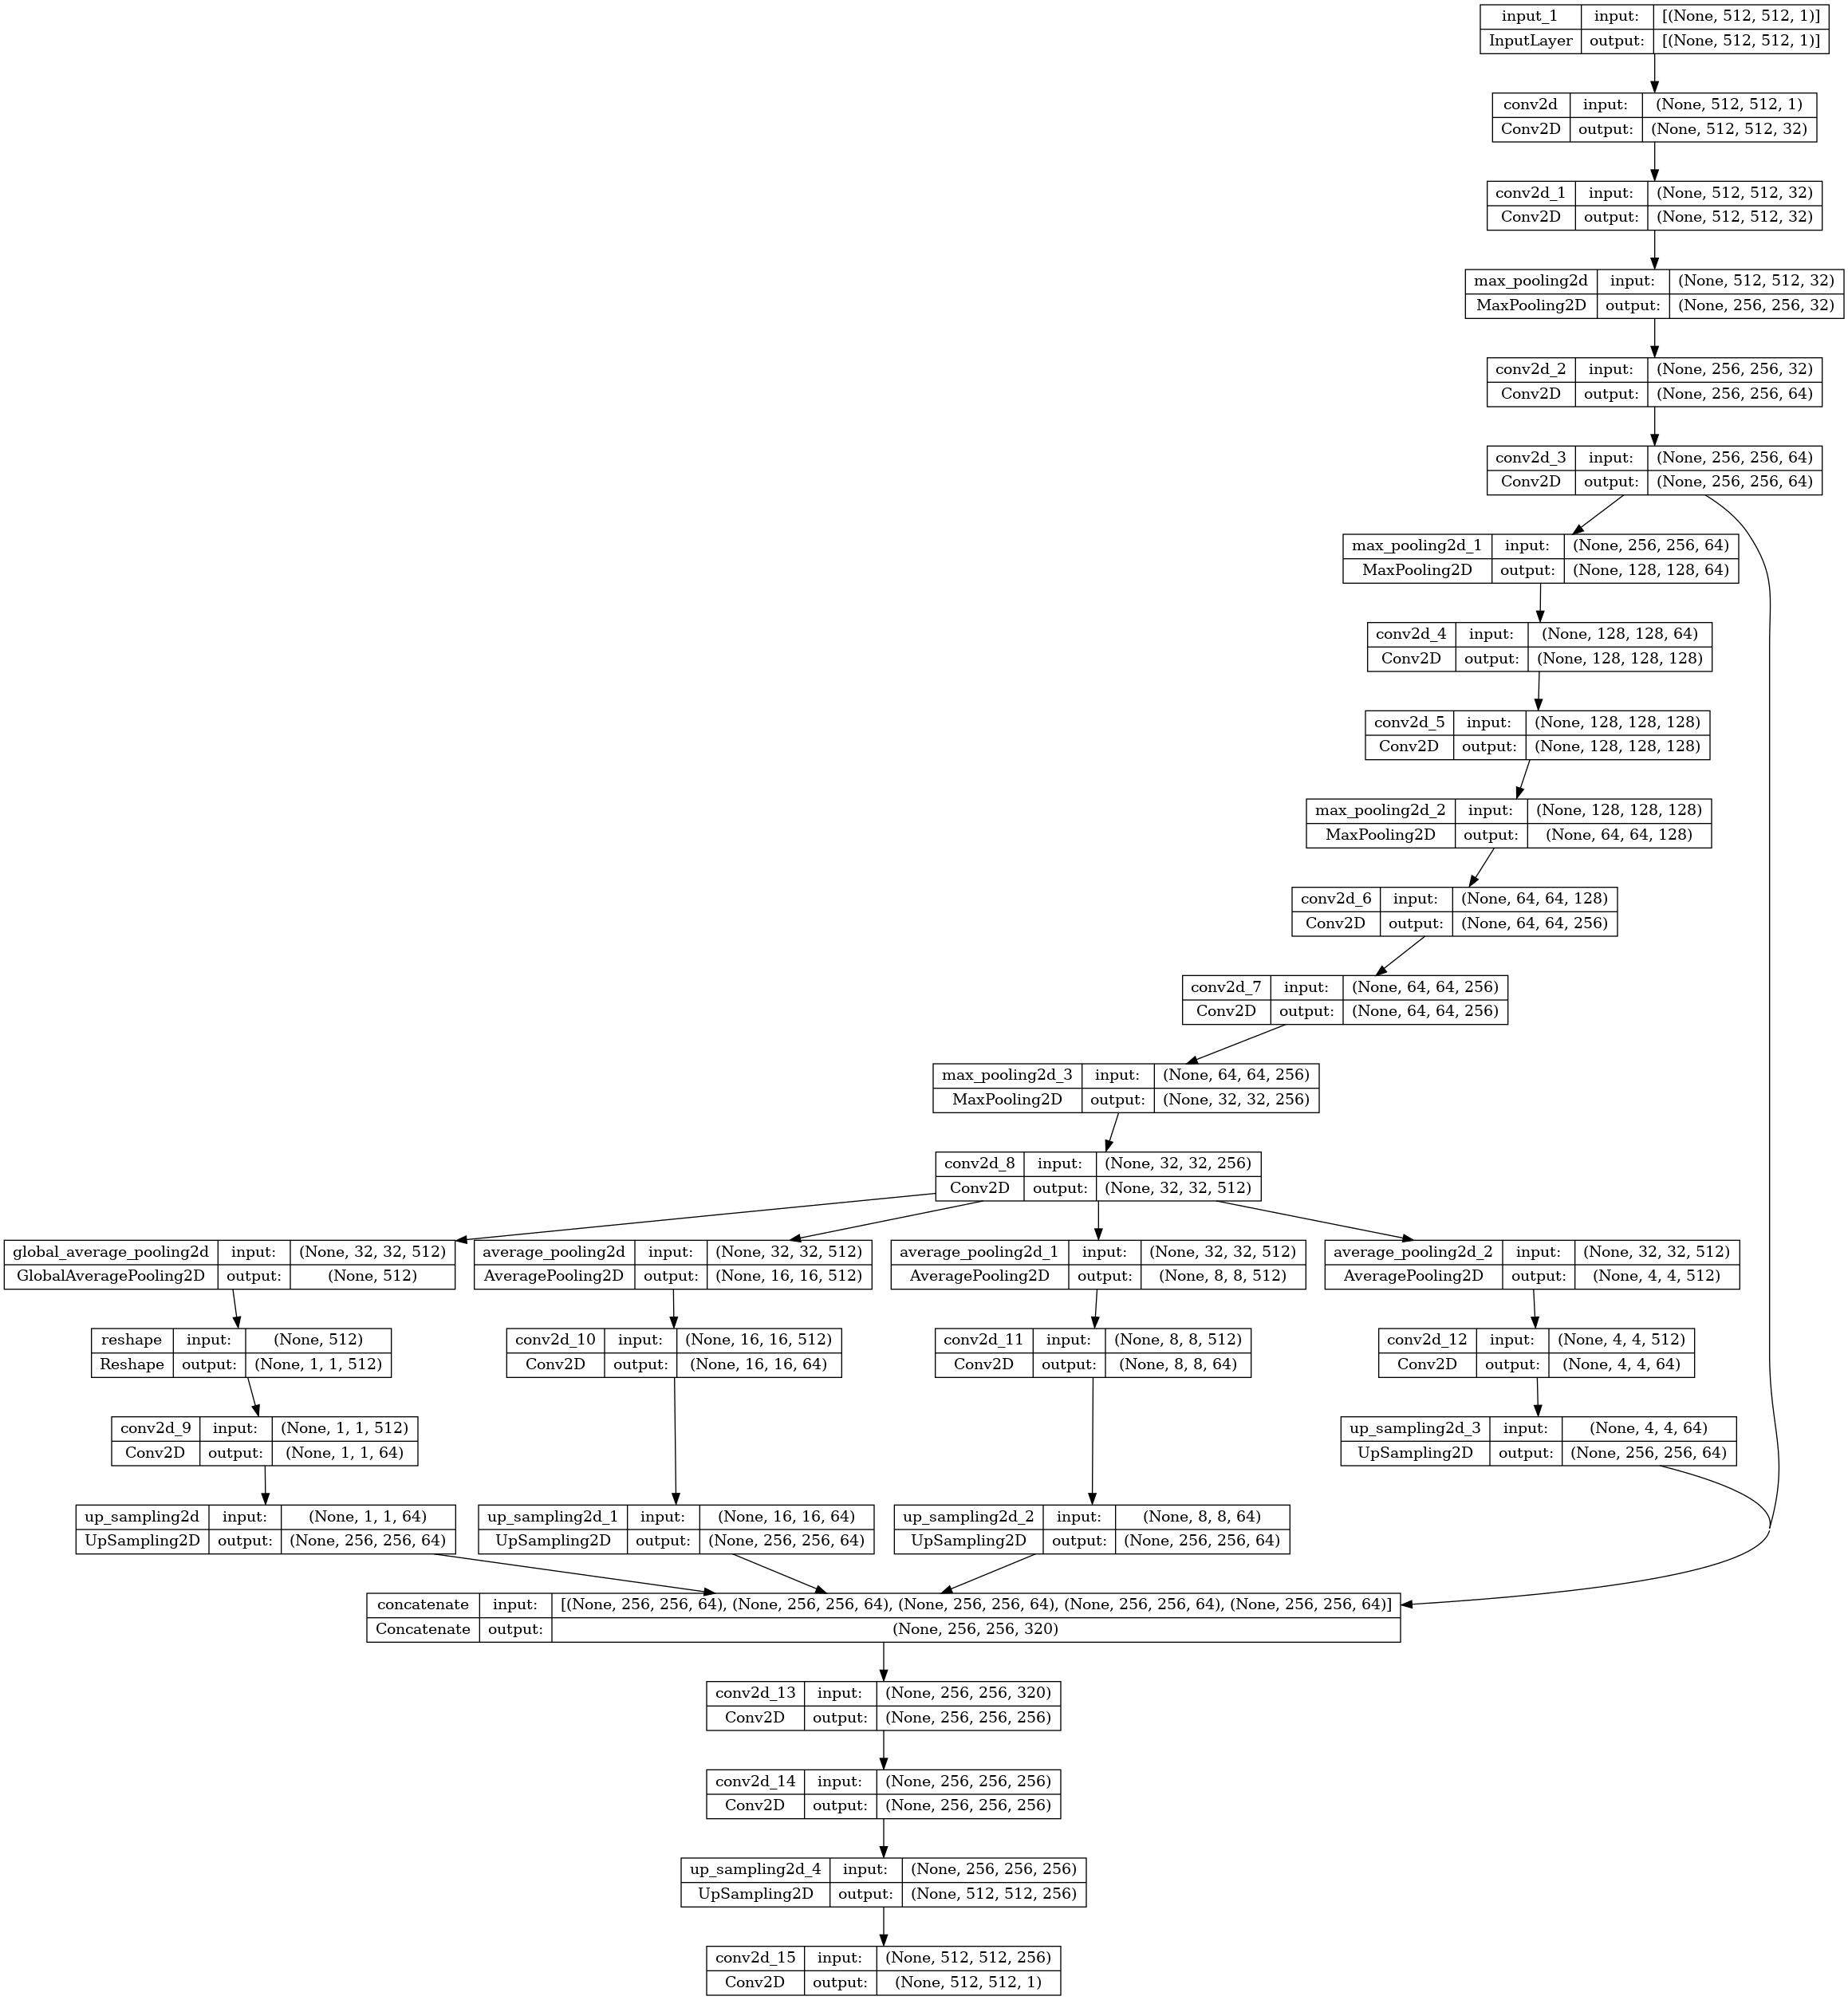

In [5]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, rankdir='TB',
to_file='model_cifar10.png')

In [6]:
X1 = np.load("/kaggle/input/data12/X1.npy")
X0 = np.load("/kaggle/input/data12/X0.npy")
Y1 = np.load("/kaggle/input/data12/mask1.npy")
Y0 = np.load("/kaggle/input/data12/mask0.npy")

In [7]:
X = np.concatenate((X1,X0),axis=0)
Y = np.concatenate((Y1,Y0),axis=0)

In [8]:
X1=0
X0=0
Y1 =0
Y0=0

In [9]:
X = X/255
Y= Y/255

In [10]:
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,Y,test_size =0.1,random_state=48)

In [11]:

X=0
Y=0


In [12]:
from tensorflow.keras.layers import Flatten
def iou_score(y_true, y_pred):
    intersection = 0 
    y_true_f = Flatten()(y_true)
    y_pred_f = Flatten()(y_pred)
    intersection =  (2.*(y_true_f * y_pred_f) + tf.keras.backend.epsilon())
    union = (y_true_f + y_pred_f + tf.keras.backend.epsilon())
    return (intersection/union)

In [13]:
model.compile(optimizer = Adam(learning_rate=0.0001),loss = "BinaryCrossentropy",metrics=[iou_score])

In [14]:
hist = model.fit(Xtrain,Ytrain,epochs=50,batch_size=8,validation_data=(Xtest,Ytest))

Epoch 1/50
162/162 [==============================] - 94s 480ms/step - loss: 0.0369 - iou_score: 0.2176 - val_loss: 0.0041 - val_iou_score: 0.0073
Epoch 2/50
162/162 [==============================] - 80s 493ms/step - loss: 0.0037 - iou_score: 0.0144 - val_loss: 0.0038 - val_iou_score: 0.0211
Epoch 3/50
162/162 [==============================] - 77s 476ms/step - loss: 0.0034 - iou_score: 0.0828 - val_loss: 0.0034 - val_iou_score: 0.1602
Epoch 4/50
162/162 [==============================] - 79s 491ms/step - loss: 0.0031 - iou_score: 0.2190 - val_loss: 0.0031 - val_iou_score: 0.2148
Epoch 5/50
162/162 [==============================] - 77s 476ms/step - loss: 0.0029 - iou_score: 0.2414 - val_loss: 0.0031 - val_iou_score: 0.1630
Epoch 6/50
162/162 [==============================] - 78s 479ms/step - loss: 0.0028 - iou_score: 0.2337 - val_loss: 0.0028 - val_iou_score: 0.2228
Epoch 7/50
162/162 [==============================] - 80s 493ms/step - loss: 0.0026 - iou_score: 0.2479 - val_loss: 0.

In [15]:
Xtrain=0
Ytrain=0

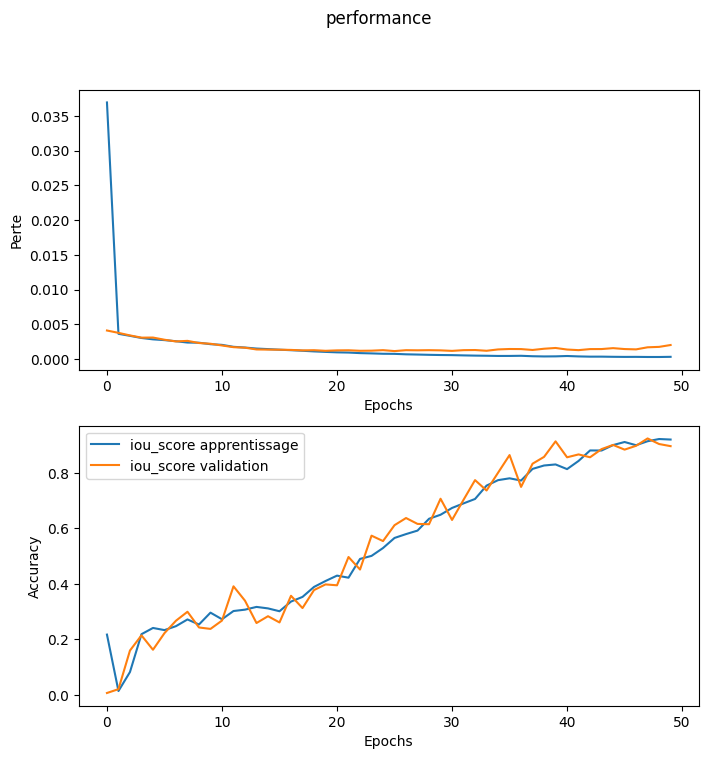

In [16]:
plt.figure(1, figsize=(8, 8))
plt.suptitle("performance") 
plt.subplot(2, 1, 1)
plt.plot(np.arange(0, 50), hist.history["loss"], label="Perte apprentissage")
plt.plot(np.arange(0, 50), hist.history["val_loss"], label="Perte validation")
plt.xlabel("Epochs")
plt.ylabel("Perte") 
plt.subplot(2, 1, 2)
plt.plot(np.arange(0, 50), hist.history["iou_score"], label="iou_score apprentissage")
plt.plot(np.arange(0, 50), hist.history["val_iou_score"], label="iou_score validation") 
plt.xlabel("Epochs") 
plt.ylabel("Accuracy")


plt.legend()


In [17]:
model.evaluate(Xtest,Ytest,batch_size=8)

18/18 [==============================] - 3s 157ms/step - loss: 0.0020 - iou_score: 0.8959


[0.002049072179943323, 0.895868182182312]

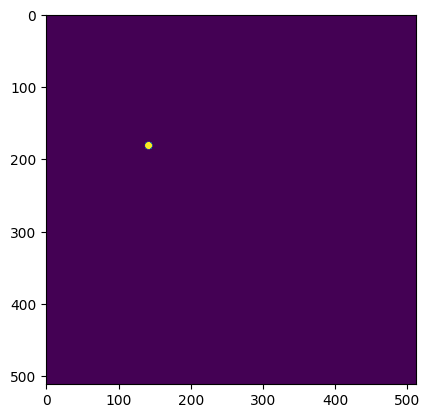

In [37]:
plt.imshow(Ytest[4])

In [39]:

y_1 = model.predict(Xtest[4].reshape((1,512,512, 1)))

1/1 [==============================] - 0s 22ms/step


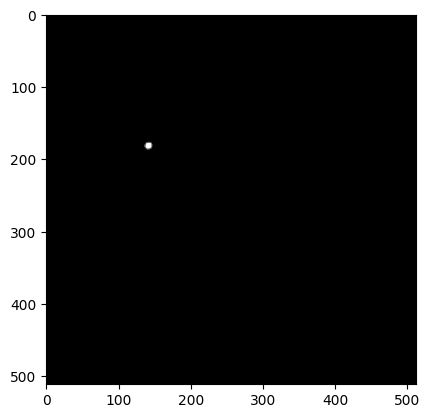

In [40]:
y_1 = y_1.reshape((512,512))
plt.imshow(y_1,cmap="gray")

In [41]:
Ytest.max()

1.0

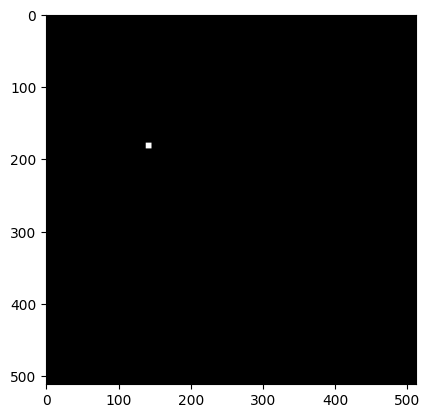

In [42]:
y_1 = np.where(y_1>0.5,1,0)
plt.imshow(y_1,cmap="gray")

In [45]:
norm_img = Xtest[4].reshape((512,512))
img = norm_img * 255

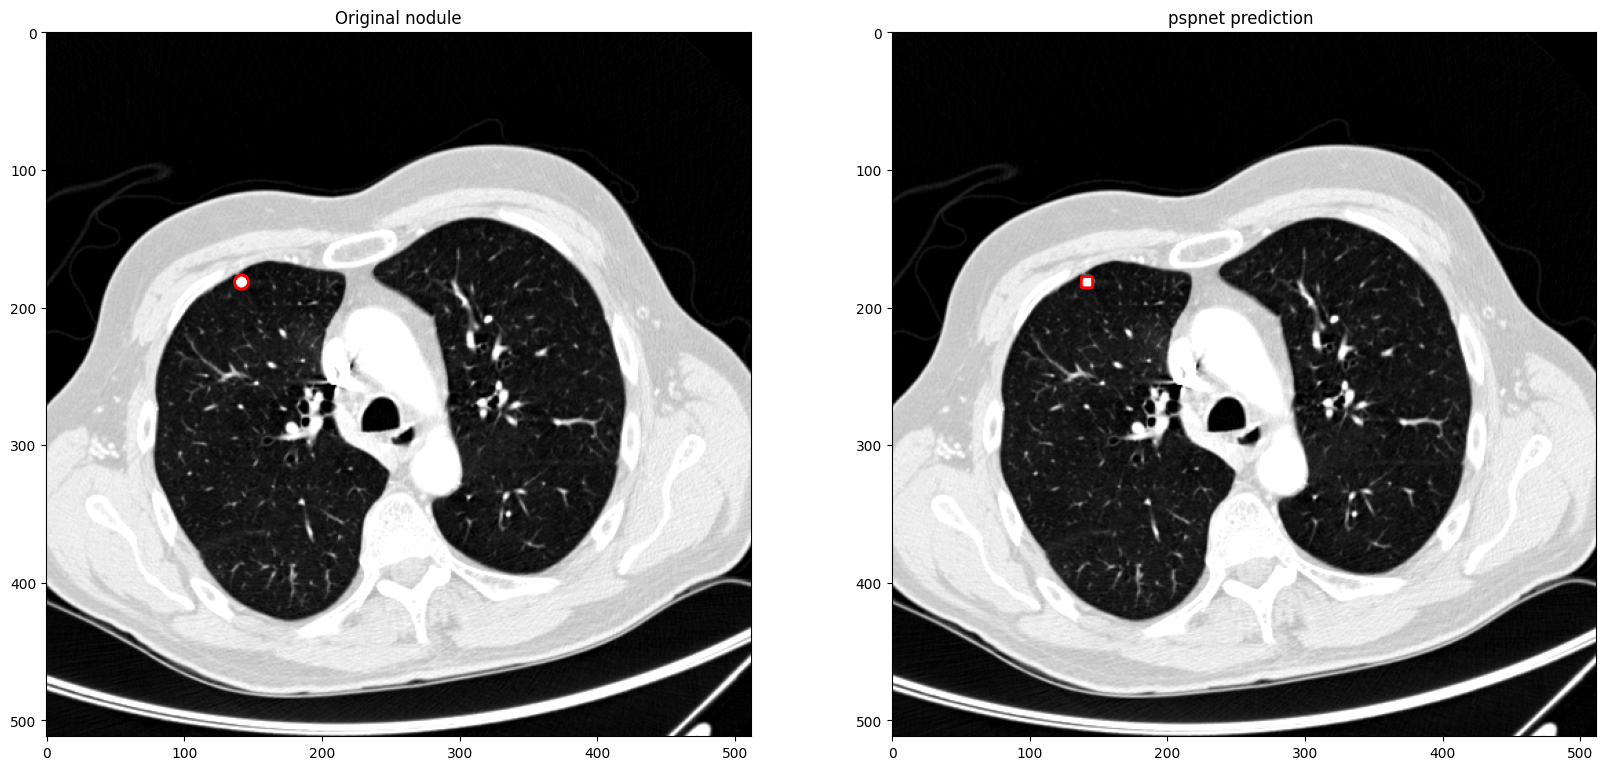

In [46]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 20))
ax1.imshow(img,cmap="gray" )
ax1.set_title('Original nodule')
ax2.imshow(img,cmap='gray')
ax2.set_title('pspnet prediction ')
ax2.contour(y_1.reshape((512,512)), levels=[0.4], colors='r', linewidths=2)
ax1.contour(Ytest[4].reshape((512,512)), levels=[0.4], colors='r', linewidths=2)
plt.show()

In [47]:
model.save("pspnet.h5")